In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Import Data

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read File

In [ ]:
# Specify the file path within your Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/hmnist_28_28_RGB.csv'  # Replace with your actual file path

# Read the file using Pandas (assuming it's a CSV file)
df = pd.read_csv(file_path)

# Data Preprocessing

Take out the label

In [ ]:
y = df['label']
x = df.drop(columns = ['label'])

In [ ]:
print(x.shape)

(10015, 2352)


Oversample to handle class imbalance

In [ ]:
#from imblearn.over_sampling import RandomOverSampler
#oversample = RandomOverSampler()
#x,y  = oversample.fit_resample(x,y)

Specify Labels

In [ ]:
print(y.nunique())

7


In [ ]:
print(y.value_counts())
#nv       6705 benign
#mel      1113 malignant
#bkl      1099 benign
#bcc       514 malignant
#akiec     327 malignant
#vasc      142 benign
#df        115 benign

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64


Replace 4, 2, 5, 3 with benign (0), and rest with malignant (1)

In [ ]:
# Replace values 1, 6, 0 with 1
y.replace({1: 1, 6: 1, 0: 1}, inplace=True)

# Replace values 4, 2, 5, and 3 with 0
y.replace({4: 0, 2: 0, 5: 0, 3: 0}, inplace=True)

In [ ]:
print(y.value_counts())
# benign 8061
# malignant 1954

0    8061
1    1954
Name: label, dtype: int64


Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
print(y.value_counts())

0    8061
1    8061
Name: label, dtype: int64


Reshape data

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (16122, 28, 28, 3)


Convert Shape

In [ ]:
from scipy.ndimage import zoom

images = x

# Define the desired size (224x224)
desired_size = (72,72)

# Upscale the images using interpolation
upscaled_images = np.zeros((images.shape[0],) + desired_size + (3,))
for i in range(images.shape[0]):
    for channel in range(3):
        upscaled_images[i, :, :, channel] = zoom(images[i, :, :, channel],
                                                 (desired_size[0] / images.shape[1], desired_size[1] / images.shape[2]))
print(upscaled_images.shape)

(16122, 72, 72, 3)


In [ ]:
x = upscaled_images
print(x.shape)

(16122, 72, 72, 3)


Standardization

In [ ]:
x = (x-np.mean(x))/np.std(x)

Train-Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [ ]:
print(Y_train.value_counts())
print(Y_test.value_counts())

1    6451
0    6446
Name: label, dtype: int64
0    1615
1    1610
Name: label, dtype: int64


# Model Training

In [ ]:
#from tensorflow.python.keras.applications import ResNet50
from keras.applications.xception import Xception

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()

Pre-trained Xception Model

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(72,72, 3)) # do not include fully connected layers
base_model.trainable = False # Freezing CNN layers

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 72, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 35, 35, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 35, 35, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 35, 35, 32)           0         ['block1_conv1_bn[0][0]

In [ ]:
from keras import layers, models
from keras.layers import GlobalAveragePooling2D, BatchNormalization

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [ ]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

In [ ]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.7645
Epoch 1: saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 24s 150ms/step - loss: 0.4885 - accuracy: 0.7645 - val_loss: 0.4512 - val_accuracy: 0.7895
Epoch 2/20
80/81 [============================>.] - ETA: 0s - loss: 0.3496 - accuracy: 0.8481
Epoch 2: saving model to best_model.h5
81/81 [==============================] - 12s 144ms/step - loss: 0.3490 - accuracy: 0.8483 - val_loss: 0.3888 - val_accuracy: 0.8221
Epoch 3/20
80/81 [============================>.] - ETA: 0s - loss: 0.2704 - accuracy: 0.8887
Epoch 3: saving model to best_model.h5
81/81 [==============================] - 12s 144ms/step - loss: 0.2702 - accuracy: 0.8886 - val_loss: 0.3693 - val_accuracy: 0.8349
Epoch 4/20
80/81 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9151
Epoch 4: saving model to best_model.h5
81/81 [==============================] - 7s 88ms/step - loss: 0.2139 - accuracy: 0.9150 - val_loss: 0.3139 - val_accuracy: 0.8690
Epoch 5/20
80/81 [============================>.] - ETA: 0s - loss: 0.1674 

# Plot Model Progression

Accuracy (training vs validation dataset)

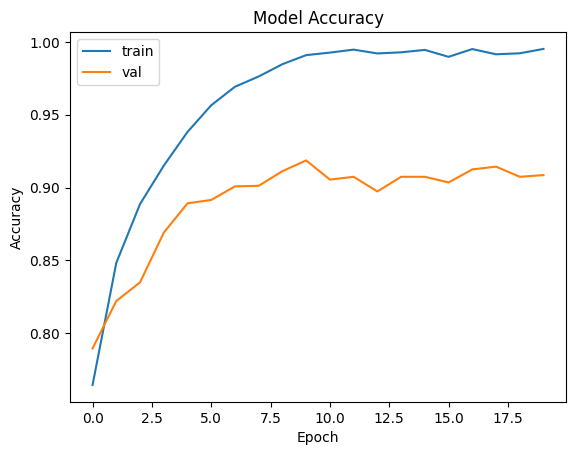

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss (training vs validation dataset)

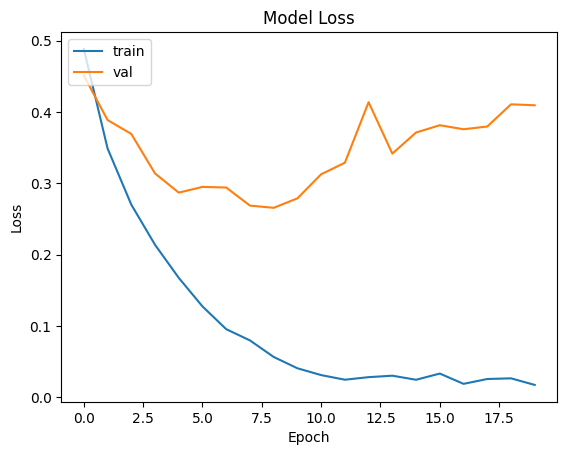

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load best model weights

In [ ]:
model.load_weights('best_model.h5')

Print model weights

In [ ]:
# Load your pre-trained model (replace 'model.h5' with your model's filename)
best_model = tf.keras.models.load_model('best_model.h5')
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/'

# Save the best model to Google Drive
best_model.save(model_save_path + 'best_model_xception.h5')

# Get the list of all layers in the model
all_layers = best_model.layers

# Loop through the layers and print their weights if they have any
for layer in all_layers:
    if layer.weights:
        print(f"Layer: {layer.name}")
        for weight in layer.weights:
            print(f"  {weight.name}:")
            print(weight.numpy())

Streaming output truncated to the last 5000 lines.
 -0.50073755  0.11798589 -0.28475678 -0.28370246 -0.26532078 -0.53861815
 -0.33143133 -0.3488695  -0.26210397 -0.40446725 -0.2769555  -0.41047463
 -0.07845338 -0.23970932 -0.32222342 -0.31411776 -0.24090257 -0.26373
 -0.31652248 -0.37661415 -0.2463493  -0.30394587 -0.18783776 -0.36304733
 -0.3203131  -0.2663212  -0.18897164 -0.48040918 -0.5202539  -0.5297499
 -0.27161258 -0.121962   -0.21954115 -0.18791257 -0.24433163  0.33330595
 -0.37526876 -0.4484028  -0.29867643 -0.2538365  -0.2395325  -0.2402393
 -0.19316691 -0.4175455  -0.48629388 -0.3128154  -0.42865938 -0.21225122
  0.6051728  -0.20863535 -0.20236151 -0.22684932 -0.27740908 -0.0935988
 -0.27004334 -0.4190852 ]
  block10_sepconv2_bn/moving_variance:0:
[0.16689159 0.31761047 0.15002413 0.14125156 0.1412408  0.1868147
 0.19674158 0.1759344  0.18522081 0.11209635 0.18198478 0.3427949
 0.3403767  0.23076218 0.17619672 0.15823323 0.17504124 0.2100139
 0.19504055 0.21424475 0.16540904

# Model Testing

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test)
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)

101/101 [==============================] - 4s 23ms/step


In [ ]:
threshold = 0.95
y_pred_labels = (y_pred_ohe >= threshold).astype(int)

In [ ]:
# Save predictions as a NumPy array
np.save('xception_predictions.npy', y_pred_labels)

In [ ]:
print(y_pred_labels)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)
print(confusion_matrix)

[[1461  154]
 [  88 1522]]


In [ ]:
from sklearn.metrics import classification_report
class_labels = ['benign', 'malignant']
report = classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.94      0.90      0.92      1615
   malignant       0.91      0.95      0.93      1610

    accuracy                           0.92      3225
   macro avg       0.93      0.92      0.92      3225
weighted avg       0.93      0.92      0.92      3225



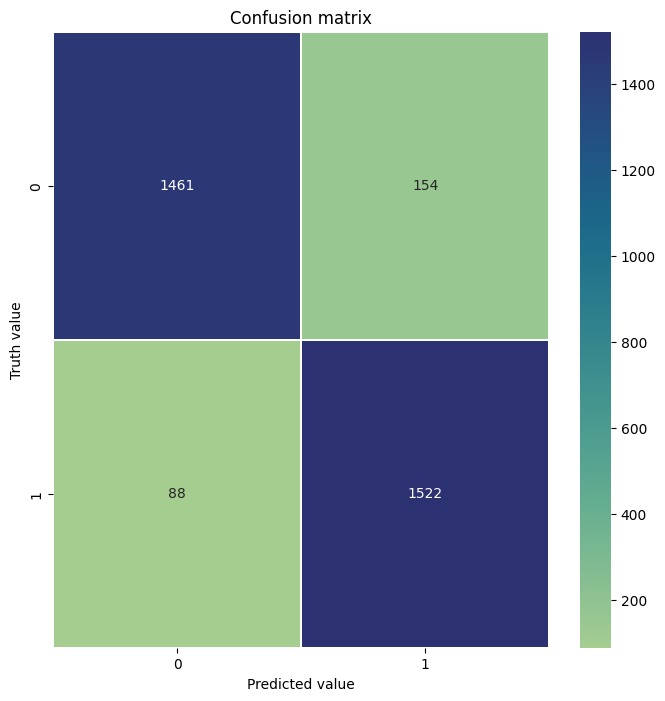

In [ ]:
import seaborn as sns

cm = confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2)
plt.title('Confusion matrix')
plt.xlabel('Predicted value')
plt.ylabel('Truth value')
plt.show()
#print(confusion_matrix(Y_test, y_pred_labels))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(Y_test, y_pred_labels)
precision = precision_score(Y_test, y_pred_labels)
recall = recall_score(Y_test, y_pred_labels)
f1 = f1_score(Y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.92
Precision: 0.91
Recall: 0.95
F1-score: 0.93


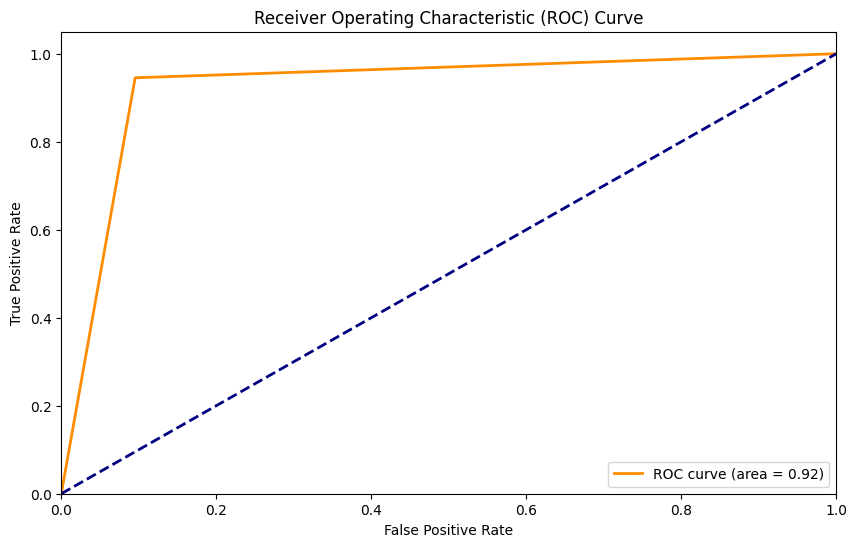

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()